In [1]:
import pandas as pd
import sqlite3
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
load_dotenv()
pd.set_option('display.max_colwidth', 0)

## Evaluate "Possible Delusion" Classification Accuracy
1. What is the level of agreement between annotators and the model?
2. What is the level of agreement amongst annotators?

### Results / Discussion
##### Classification Performance
Current performance is unlikely to lead to a satisifying experience for qualitative researchers. 73% recall indicates that ~1/4 comments with evidence of possible delusion are incorrectly classified and would be filtered if the model were used as a pre-screen to human review. 56% precision indicates ~1/2 of comments included for human review would not be relevant. 87% accuracy is misleading as a success metric and is primarily a due to class imbalance.

The model signficantly outperforms a naive bayes classifier built using a TF-IDF vectorizor, which ends up classifying all comments as the negative class. This suggests the value of pre-trained embeddings and transformer-based models for this use case. Embeddings are important in that relate words with similar meanings which may perform a similar role  in classification, for example "think", "convinced" and "believes". Transformers are important in that contextual cues underlying the classification may span over many tokens, or even multiple sentences, rather than just a 1-2 tokens.

This model would require a different prompting strategy or additional fine-tuning to perform intuitively for qualitative researchers.

##### Excerpt Extraction

A cursory review comparing extracted excerpts is fairly impressive. In a random sample of cases where the model and annotator classified "possible delusion", 8/10 included overlapping text. 

In [2]:
qry = """
SELECT 
    co.ROWID, 
    co.comment_text, 
    cl.is_possible_delusion AS model_prediction,
    an.possible_delusion AS annotated_class,
    cl.excerpt AS model_excerpt,
    an.excerpt AS annotated_excerpt,
    cl.prompt_tokens,
    co.has_delu_keyword
FROM classifications cl
INNER JOIN comments co ON cl.input_text_id = co.ROWID
AND cl.prompt_version = 5
INNER JOIN annotated an ON co.ROWID = an.comment_rowid
WHERE an.batch = 2 -- the test set
"""
confusion_df = pd.read_sql(qry, con=sqlite3.connect(os.path.join('..', 'data', os.getenv('SQLITE_DB_NAME'))))
print(confusion_df.shape[0], 'comments available for comparison')

324 comments available for comparison


In [9]:
confusion_df.sample(5)

,rowid,comment_text,model_prediction,annotated_class,model_excerpt,annotated_excerpt,prompt_tokens,has_delu_keyword
135,32538,"O!! How I wish some one had told me about you when my husband was going through this. It was a time of anger and misunderstandings between us. I had asked our Dr. do you think he has Alzheimer’s, he laughed at me & said he is smarter then both of us! I didn’t ask how smart he was, I ask do you think he has Alzheimer’s!!! Several Dr.s later a smart Dr. without ever knowing or seeing me said I can’t deal with your husband, I begged him to keep seeing him as every Dr. would fire him as a pt. He diagnosed him!!! He would stay an hour & more with us most visits, after even the nurses had left the office. He would let us out to our car through the side door.",0.0,0,"""I had asked our Dr. do you think he has Alzheimer’s, he laughed at me & said he is smarter then both of us!""",None,850,0
249,125805,"Mom passed 11/27/19, age 90, Alzheimer’s patient. Long-term memory in tact for the most part (did not remember her last grandchild after a weekend visit). She did however remember her living 2 girls and 1 who’d past and finally remembered that she’d been told she’d past 3 years prior. She did remember me, my sister, her husband, and my husband. Thank God. But it would’ve been okay if she didn’t; I knew it wasn’t her not remembering, it was Alzheimer’s, that little thing that invaded her mind about 20 years prior. ❤️ PERSON and PERSON 🌈",0.0,0,N/A,None,836,0
50,13164,My dad takes care of my grandparents with my grandma having Alzheimer's and she would ask the same questions over and over. My dad would get so flustered with her but if I show him this video maybe he can help her reduce asking the same thing over and over.,0.0,0,N/A,None,738,0
72,18595,My mom was diagnosed with frontal temporal dementia back in 2017 had a stroke 2018 things started to decline quickly after that. Me and my sister help care for her. At this point they think she might have early alzheimer's she is only 63 waiting on a mri for the new diagnosis. She is in diapers can no longer bathe herself needs help dressing and doing her hair. We have to clean and cook for her. She is still able to walk talk and feed herself. She drastically lost weight and seems to be aging really fast. She's so fragile now. It's hurts thinking about what life used to be and not knowing how much time is left.,0.0,0,N/A,None,819,0
75,19183,So I just brought a medical alert systems to my moms yesterday because she thought it would be a good idea and so did I. Mom still insists on living alone. She actually liked the wristlet call button. This morning when I called her she screamed at me to get it out of her house. I told her I would remove it tomorrow after wasting time trying to tell her she asked for it. That was my first mistake. I then received a call from the medical alert system that my mom was calling them to remove it from the home. In fact she called 5 times. I called mom to tell her I would be there to remove it. I then received a call stating there was no power at my moms and so did the 3 people on the call list. I called mom to ask her if she disconnected the system and she did. I already cancelled the system and will be returning it tomorrow. This was done for her safety but I have no choice. So I guess yes removing the object will stop this confrontation but make life even harder than it is already for me.,0.0,1,N/A,This morning when I called her she screamed at me to get it out of her house. I told her I would remove it tomorrow after wasting time trying to tell her she asked for it. That was my first mistake.,911,0


In [15]:
# interesting... the model caused a parsing error in this comment. Appears to be the only issue in a set of 324 comments
''''
had dementia: true
Excerpt: "He passed away this January.. I never really got to know him💔"
'''
confusion_df.loc[confusion_df.model_prediction.isna() | confusion_df.annotated_class.isna(), :]

,rowid,comment_text,model_prediction,annotated_class,model_excerpt,annotated_excerpt,prompt_tokens,has_delu_keyword
251,126734,My grandpa had dementia (very similar to this) but he got to the point where he couldn't talk. He would just sit there and stare into nothing. He passed away this January.. I never really got to know him💔 \n\nPERSON grandpa,NaN,0,None,None,739,0


In [3]:
orig_size = confusion_df.shape[0]
confusion_df.dropna(inplace=True, subset=['model_prediction', 'annotated_class'])
print('Dropped', orig_size - confusion_df.shape[0], 'model prediction with a missing classification')

Dropped 1 model prediction with a missing classification


#### Classification Report - Including Comments with *Obvious* Delusion Keywords

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
print('Underlying prevalence per annotators: {:.2%}'.format(confusion_df.annotated_class.mean()), '\n\n')
print(classification_report(confusion_df.annotated_class, confusion_df.model_prediction, target_names=["Negative", "Positive"]), '\n\n')
print(confusion_matrix(confusion_df.annotated_class, confusion_df.model_prediction), '\n\n')
print(confusion_matrix(confusion_df.annotated_class, confusion_df.model_prediction, normalize='true'))

Underlying prevalence per annotators: 17.34% 


              precision    recall  f1-score   support

    Negative       0.94      0.90      0.92       267
    Positive       0.59      0.73      0.66        56

    accuracy                           0.87       323
   macro avg       0.77      0.81      0.79       323
weighted avg       0.88      0.87      0.87       323
 


[[239  28]
 [ 15  41]] 


[[0.89513109 0.10486891]
 [0.26785714 0.73214286]]


#### Classification Report - Excluding Comments with Delusion Keywords
This is a more relevant use case. Simple regex methods can retrieve instances where the commenter uses "delusion", "delusional disorder" etc. For the LLM to provide value, it needs to classify accurately in the absence of obvious keywords.

In [5]:
confusion_df_ex_delu_keyword = confusion_df.loc[confusion_df.has_delu_keyword == 0, :]
print('Underlying prevalence per annotators: {:.2%}'.format(confusion_df_ex_delu_keyword.annotated_class.mean()), '\n\n')
print(classification_report(confusion_df_ex_delu_keyword.annotated_class, confusion_df_ex_delu_keyword.model_prediction, target_names=["Negative", "Positive"]), '\n\n')
print(confusion_matrix(confusion_df_ex_delu_keyword.annotated_class, confusion_df_ex_delu_keyword.model_prediction), '\n\n')
print(confusion_matrix(confusion_df_ex_delu_keyword.annotated_class, confusion_df_ex_delu_keyword.model_prediction, normalize='true'), '\n\n')

Underlying prevalence per annotators: 15.34% 


              precision    recall  f1-score   support

    Negative       0.95      0.90      0.92       265
    Positive       0.56      0.73      0.64        48

    accuracy                           0.87       313
   macro avg       0.76      0.81      0.78       313
weighted avg       0.89      0.87      0.88       313
 


[[238  27]
 [ 13  35]] 


[[0.89811321 0.10188679]
 [0.27083333 0.72916667]] 




##### Where is the model getting confused? Error analysis
Since the model's predictions are unexplainable, I'll resist the urge to interpret... It is interesting that two of the FP cases have a hallucinated excerpt. Not sure this is related to the classification task, as the tokens produced to indicate a positive class occur before exceprt extraction.

There is no apparent relationship between length of the comment text and error type. The sample is too small to make any definitive conclusions anyway.

In [6]:
# Github copilot wrote this :)
confusion_df_ex_delu_keyword.loc[:, "error_type"] = confusion_df_ex_delu_keyword.apply(lambda x: "FN" if x.annotated_class == 1 and x.model_prediction == 0 else "FP" if x.annotated_class == 0 and x.model_prediction == 1 else "TN" if x.annotated_class == 0 and x.model_prediction == 0 else "TP", axis=1)

C:\Users\david\AppData\Local\Temp\ipykernel_16504\2878664907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confusion_df_ex_delu_keyword.loc[:, "error_type"] = confusion_df_ex_delu_keyword.apply(lambda x: "FN" if x.annotated_class == 1 and x.model_prediction == 0 else "FP" if x.annotated_class == 0 and x.model_prediction == 1 else "TN" if x.annotated_class == 0 and x.model_prediction == 0 else "TP", axis=1)


In [7]:
confusion_df_ex_delu_keyword.loc[confusion_df_ex_delu_keyword.error_type == "FP", :].sample(5)

,rowid,comment_text,model_prediction,annotated_class,model_excerpt,annotated_excerpt,prompt_tokens,has_delu_keyword,error_type
156,41442,"Teepa thank you very much. The comment about urinary incontinence and the person doesn't care he's wet all the time. My LOWD just doesn't know or care.. my house and car smell like urine 24/7. I'm using carpet cleaner for cats, baking powder to night a grocery hard a sale on lavender scented plug in air wick. The person who said "" a book needs to be in print or printable suggestions"" Urologist can't help with out surgery and only a 40% success rate. My husband can not have surgery anymore. His diagnoses is vascular dementia but his brother 10years older was diagnosed with Alzheimer's disease. I've grown to believe he has mixed symptoms. Hallucinations, doesn't know where he is and aggressive when I ask him to do anything wear depends etc. Thanks I'm sorry but have ro say your adaptive ability sitting in a Wendy parking lot but still your positive words are comforting",1.0,0,"""Hallucinations, doesn't know where he is and aggressive when I ask him to do anything wear depends etc.""",None,879,0,FP
88,20913,I am being told by friends that I should place my husband. He is getting mad at our one cat. She likes to be on him for his warmth.,1.0,0,"""He is convinced that she is trying to kill him.""",None,715,0,FP
320,178357,"Such a cruel illness! My gran has it and she gets so upset and scared some days, just like your PERSON! She knows it's her brain playing tricks on her but gets so confused. She knows she's being looked after, but she can't shake the feeling that she's all alone in this and that people will just leave her! Heart breaking! Thank you for sharing your journey. It's helpful ❤️",1.0,0,"""She knows it's her brain playing tricks on her but gets so confused. She knows she's being looked after, but she can't shake the feeling that she's all alone in this and that people will just leave her!""",None,768,0,FP
198,76479,"Doctor: You have cancer and dementia. \n\nPatient: Whew! For a second there, I was afraid you were going to tell me I had cancer! At least I don’t have dementia!",1.0,0,"""At least I don't have dementia!""",None,728,0,FP
0,866,"Contacting the council on aging here in Indiana was key for me. I had support, someone to talk to, and guidance for placement in a nursing home. A senior lawyer is absolutely necessary. Since Mom's diagnosis, I realize more and more, that is not really her, but her disease. I also believe the social worker at her nursing home is as much for me as for her. Also, because I was a teacher, I started keeping an antidotal record with dates and times of odd behaviors. Her doctor said that was most valuable.",1.0,0,"""Since Mom's diagnosis, I realize more and more, that is not really her, but her disease.""",None,799,0,FP


In [8]:
confusion_df_ex_delu_keyword.loc[confusion_df_ex_delu_keyword.error_type == "FN", :].sample(5)

,rowid,comment_text,model_prediction,annotated_class,model_excerpt,annotated_excerpt,prompt_tokens,has_delu_keyword,error_type
40,11612,"Dr, Natali, take a bow, AGAIN! Excellent video. My wife has been in an Alzheimer's care centre for nearly 3 years. I have noticed that since April (when we were able to visit in person and take her home for a Sunday visit) she seems to be marginally better. I think it is due to the fact I visit every day and follow your advice on care giving. She has no idea that I am her husband of 55 years, just a trusted friend.\nPlease keep up this critical service.\nPERSON",0.0,1,N/A,"She has no idea that I am her husband of 55 years, just a trusted friend.",797,0,FN
95,22303,Thank you! I needed to hear this. I’m struggling with the fact it my mom lives with me and I lost all my helpers. Mom 85 watches me and wants me in her sight at all times during the day. If I leave the room she calls me. She thinks all my pictures on my walls and the tv are people staring at her through the windows. She has sundowners. I had just got a system in place where my siblings and adult children were helping daily while I went to work and to give me a break now because of PERSON 19 they’re not able to come for almost 3 months now! Also I return to work in August and my siblings suggest I hire a caregiver to help me from an outside source and that terrifies me. Any suggestions would be helpful. I’ve contact her Dr.,0.0,1,"""She thinks all my pictures on my walls and the tv are people staring at her through the windows.""",She thinks all my pictures on my walls and the tv are people staring at her through the windows.,854,0,FN
67,17176,"I am a care giver for my husband, I am 67 and he turned 83. I didn't have a problem taking the keys away because his eye doctor said he can't see to drive. One problem solved. I do have problem hearing him accuse me of something and most days, I ignore him, but when I'm tired, I argue back. He is in late stage but is still mobile and gets around with his walker. He can still feed himself, he has no bowel or urinary control, and that is my part to clean him up. I don't go to bed till 12, it's my time to pray and just have me time. I try to get out for a walk everyday, my son lives with us and he will call me if he goes in his pants. Some days he will call me and wakes me up at 2:30 - 3:00 for breakfast. That's the only thing that makes me angry. He doesn't know time, but the last couple days he has slept through till at least 6. Some days I feel like I have a baby in the house again.",0.0,1,N/A,"I do have problem hearing him accuse me of something and most days, I ignore him, but when I'm tired, I argue back.",910,0,FN
64,16095,"Thank you for these points regarding the ""real"" feelings one experiences whether suffering from dementia or not!\nMy mother passed nearly 20 years ago, and my father, who has PERSON dementia, finds himself experiencing her death rather constantly. His dementia has impacted his memory in many ways, and in particular many of his memories of the past 30 years or so.\nHe ""discovers"" she has passed on a regular basis - once or twice a week - and each time it is as if she just passed yesterday. He goes through all of the grieving as such too. \nAt first I thought simply reminding him of the time differential should make him realize how much time passed, but he simply disregarded whatever I would say and continue on with his grieving process.\nNow I just try to be supportive and acknowledge his feelings without trying to place his memories in a different time for him. He goes on for a couple of hours like this, and eventually I can distract him into something else.\n\nHis feelings of grief are certainly real no matter how misplaced in time they may be. Helping him through the grief rather than trying to fix his memory is really the only way to work through what he is experiencing.",0.0,1,N/A,"He ""discovers"" she has passed on a regular basis - once or twice a week - and e

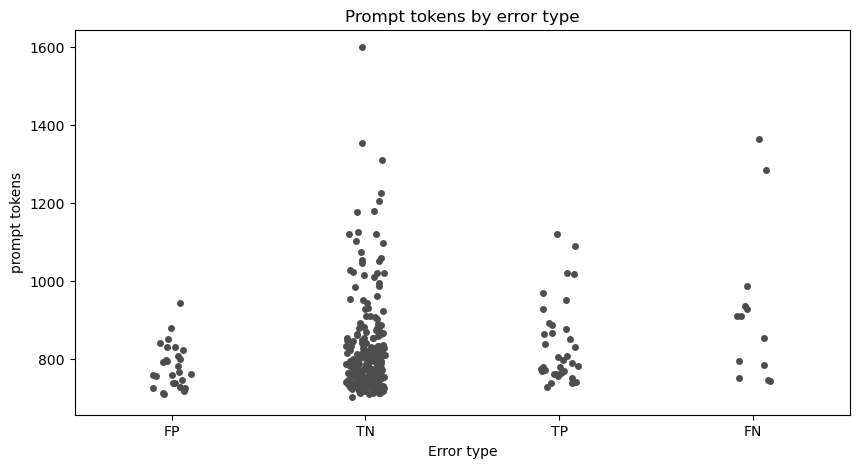

In [60]:
# create boxplots showing average prompt token for each error type, include all instances as points
fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(x="error_type", y="prompt_tokens", data=confusion_df_ex_delu_keyword, ax=ax, color=".3")
ax.set_title('Prompt tokens by error type')
ax.set_xlabel('Error type')
ax.set_ylabel('Prompt tokens')
plt.show()

##### Extracted excerpts for TP
Looks pretty great. In 8/10 cases, annotator and the LLM pulled similar excerpts.

In [9]:
confusion_df_ex_delu_keyword.loc[
    (confusion_df_ex_delu_keyword.annotated_class == 1) & (confusion_df_ex_delu_keyword.model_prediction == 1), 
    ["comment_text", "model_excerpt", "annotated_excerpt"]].sample(10)

,comment_text,model_excerpt,annotated_excerpt
248,"With all due respect and deference... my uncle who I loved and he loved me! He never had children and I was like a daughter to him. He married a woman who was a nasty nasty nasty ass person! She controls all the Monies in the househole and control where he was at all times and the list goes on! Basically she was narcissistic! My uncle died three years ago they lived in another state... this past weekend I went to go visit her because I guess he loved her and I definitely love him! I walked into a nightmare she was not taking care of herself and I notice a great deal paranoia in her, she thought everyone was stealing from her! All my life I kissed her ass because I knew as a little girl, that I would not be able to see my uncle... that's how controlling she was! All I have to say, PERSON bless the caretakers that will soon have to be taken care of her! She she does have her family check on her she has Meals on Wheels also a cleaning lady and someone who comes to take care of her lawn her prescriptions are delivered her refrigerator was stocked she has a lot of money however, I had to walk away and wash my hands of it all! The past Sunday when I was leaving all my bags were packed at the front door and I said out loud I'm leaving now! She was nowhere to be found I walked into the master bedroom and there she was going to her jewelry box! I slept in my uncle's room and his ashes were there right beside me! I hope she doesn't call and ask me if I had taken some of his ashes! Ioi","""She thought everyone was stealing from her!""","this past weekend I went to go visit her because I guess he loved her and I definitely love him! I walked into a nightmare she was not taking care of herself and I notice a great deal paranoia in her, she thought everyone was stealing from her!"
265,"My dad is 88 years old and everything you said I have experienced and you have helped me very much with how to handle this better. I have always been the type of person to say it like is! Even if it is confrontational, but that has got me nowhere with my dad except for huge arguments! He always tells me that he was a business man for 40 years and do you think I'm stupid!","""He always tells me that he was a business man for 40 years and do you think I'm stupid! He says he has a business meeting in the morning and he has to go to work.""",He always tells me that he was a business man for 40 years and do you think I'm stupid!
282,"I left a comment similar on Wendigoons Everywhere at the End of Time video, but it’s heartbreaking watching someone forget everything. My grandma had ovarian cancer that spread to her spine and, eventually, her brain thus her memory started to decline. It was small stuff and hesitations when asked something, then repeating herself. Then the most heart wrenching was when she thought I was my dad, even though he was in the room next to her. It’s my biggest fear to end up forgetting everyone and everything.","""Then the most heart wrenching was when she thought I was my dad, even though he was in the room next to her.""","Then the most heart wrenching was when she thought I was my dad, even though he was in the room next to her."
42,"A helpful approach for many situations - thanks as always! However, what to do when LOWD is making demands as in ""You must drive me to police station right now because they have my clothes that the thieves took!"" Not sure how to apply the VERA steps... her perseveration is strong and even if we don't correct or say ""sorry that happened"" etc. she goes back to making the demand. Can go on for hours...","""They have my clothes that the thieves took!""","""You must drive me to police station right now because they have my clothes that the thieves took!"""
57,"Thank you. I'm alone with no help and my 86 yo mom has dementia and aft midnight she's says is day, charging around with 2 different canes,like captain ahab,or edwardscissorhands.i need help. She is che

In [43]:
from sklearn.naive_bayes import BernoulliNB
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
porter_stemmer = PorterStemmer()

def porterstemmer_tokenizer(rpt_str):
    words = re.sub(r'\b[^\d\w\w+]\b', " ", rpt_str).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r'\b[^\d\w\w+]\b', 
                             tokenizer=porterstemmer_tokenizer, lowercase=True, 
                             analyzer="word", stop_words="english")

In [44]:
qry = """
SELECT 
    co.ROWID, 
    co.comment_text, 
    cl.is_possible_delusion AS model_prediction,
    an.possible_delusion AS annotated_class,
    cl.excerpt AS model_excerpt,
    an.excerpt AS annotated_excerpt,
    cl.prompt_tokens,
    an.batch
FROM classifications cl
INNER JOIN comments co ON cl.input_text_id = co.ROWID
AND cl.prompt_version = 5
INNER JOIN annotated an ON co.ROWID = an.comment_rowid
WHERE co.has_delu_keyword = 0
"""
baseline_df = pd.read_sql(qry, con=sqlite3.connect(os.path.join('..', 'data', os.getenv('SQLITE_DB_NAME'))))

orig_size = baseline_df.shape[0]
baseline_df.dropna(inplace=True, subset=['model_prediction', 'annotated_class'])
print('Dropped', orig_size - baseline_df.shape[0], 'model prediction with a missing classification')

Dropped 1 model prediction with a missing classification


In [45]:

dev_X = baseline_df.loc[baseline_df.batch == 1, 'comment_text']
dev_y = baseline_df.loc[baseline_df.batch == 1, 'annotated_class']

val_X = baseline_df.loc[baseline_df.batch == 2, 'comment_text']
val_y = baseline_df.loc[baseline_df.batch == 2, 'annotated_class']

#apply to development set - learn vocabulary and data term matrix (dtm)
X_dev_dtm = vectorizer.fit_transform(dev_X)

#presence/absence of feature
clf = BernoulliNB(alpha=1.0)

clf.fit(X_dev_dtm, dev_y)

#apply vectorizer with known vocabulary onto validation set
X_val_dtm = vectorizer.transform(val_X)

predictions = clf.predict(X_val_dtm)
print(clf, classification_report(val_y, predictions, target_names=['Negative', 'Positive']))

c:\Users\david\anaconda3\envs\spacy_experimental\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\david\anaconda3\envs\spacy_experimental\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'so

BernoulliNB()               precision    recall  f1-score   support

    Negative       0.85      1.00      0.92       265
    Positive       0.00      0.00      0.00        48

    accuracy                           0.85       313
   macro avg       0.42      0.50      0.46       313
weighted avg       0.72      0.85      0.78       313



c:\Users\david\anaconda3\envs\spacy_experimental\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\david\anaconda3\envs\spacy_experimental\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\david\anaconda3\envs\spacy_experimental\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

# Evaluate Instruction Following
The actual prompt used for the `da-vinci-text-3` model can be found at `prompts/davinci_base_prompt_v5.txt`

1. Did the model always extract an excerpt when making a positive classification?
2. Did the model incorrectly extract an exctract when making a negative classifiction?
3. Are extracted excerpts found in the original text?

Transformations applied to evaluate these questions:
1. Remove all punc and case from comment and excerpt
2. Treat N/A, None, and No Excerpt as no excerpt. None and No Excerpt were an error, or should we just say... unanticipated?
3. Iterate all substrings of comment with the same length as the excerpt and calculate string similiarty. Take the maximum similarity.

### Conclusions
Without considering the relevance of the excerpt to a possible delusion classification, the model performed well in extracting excerpts that were actually found in the original text. In some cases, it's arguable that the model made improvements by correcting spelling, or inferring the referenced entity's pronoun when it was ommitted. However, it seems perferable to extract an exact excerpt and use deterministic methods to clean it up from there. Notably, the GPT series are know to correct themselves when errors are explicitly pointed out. Hence, it may be possible to use a function to identify excerpt extraction errors, and ask for a new result... Definitely a confusing computing paradigm!

In [11]:
qry = """
SELECT co.ROWID, co.comment_text, cl.is_possible_delusion, cl.excerpt, cl.prompt_tokens FROM classifications cl
INNER JOIN comments co ON cl.input_text_id = co.ROWID
WHERE cl.prompt_version = 5
"""
llm_class_df = pd.read_sql(qry, con=sqlite3.connect(os.path.join('..', 'data', os.getenv('SQLITE_DB_NAME'))))
llm_class_df.shape

(1351, 5)

In [12]:
is_positive = llm_class_df['is_possible_delusion'] == 1
llm_class_df["comment_text_clean"] = llm_class_df["comment_text"].str.replace(r'[^a-zA-Z0-9]', '', regex=True).str.lower()
llm_class_df["excerpt_clean"] = llm_class_df["excerpt"].str.replace(r'[^a-zA-Z0-9]', '', regex=True).str.lower() # added lower
llm_class_df.loc[llm_class_df.excerpt.str.lower().isin(["n/a", "none", "no excerpt"]), "excerpt_clean"] = None
llm_class_df["excerpt_clean_len"] = llm_class_df["excerpt_clean"].str.len()
llm_class_df["excerpt_in_comment"] = llm_class_df.apply(lambda row: row["excerpt_clean"] in row["comment_text_clean"] if row["excerpt_clean"] else None, axis=1)

def get_substrings_len_k(string, k):
    return [string[i:i+int(k)] for i in range(len(string)-int(k)+1)]

# sheds tear for using pandas apply
llm_class_df["comment_text_clean_substr"] = llm_class_df.apply(lambda x: get_substrings_len_k(x["comment_text_clean"], x["excerpt_clean_len"]) if pd.notnull(x["excerpt_clean_len"]) else None, axis=1)
def max_substr_ratio(row):
    if row["comment_text_clean_substr"] is None:
        return None
    else:
        return max([difflib.SequenceMatcher(None, row["excerpt_clean"], s).ratio() for s in row["comment_text_clean_substr"]])
llm_class_df["max_diff_ratio"] = llm_class_df.apply(lambda x: max_substr_ratio(x), axis=1)

##### 1. Did the model always extract an excerpt when making a positive classification?
Yes, it appears so.

In [15]:
llm_class_df["has_excerpt"] = llm_class_df["excerpt_clean"].notnull()
print(llm_class_df.loc[llm_class_df.is_possible_delusion == 1, "has_excerpt"].value_counts())
print(llm_class_df.loc[llm_class_df.is_possible_delusion == 1, "has_excerpt"].value_counts(normalize=True))

True    290
Name: has_excerpt, dtype: int64
True    1.0
Name: has_excerpt, dtype: float64


##### 2. Did the model incorrectly extract an exctract when making a negative classifiction?
Incorrectly extracted an excerpt 8% of the time

In [16]:
print(llm_class_df.loc[llm_class_df.is_possible_delusion == 0, "has_excerpt"].value_counts())
print(llm_class_df.loc[llm_class_df.is_possible_delusion == 0, "has_excerpt"].value_counts(normalize=True))

False    972
True     88 
Name: has_excerpt, dtype: int64
False    0.916981
True     0.083019
Name: has_excerpt, dtype: float64


##### 3. Are extracted excerpts found in the text?
This is a more nuanced answer. 83% of the time, the original string (remove case and punc) was found in the original text.

In [18]:
llm_class_df_has_excerpt = llm_class_df.loc[llm_class_df.has_excerpt]
print(llm_class_df_has_excerpt.excerpt_in_comment.value_counts())
print(llm_class_df_has_excerpt.excerpt_in_comment.value_counts(normalize=True))

True     316
False    62 
Name: excerpt_in_comment, dtype: int64
True     0.835979
False    0.164021
Name: excerpt_in_comment, dtype: float64


#### Max Similarity >0.9
When calculuating a maximum diff ratio for substrings of equal length to the extracted excerpt, observe that nearly *25% have a string similarity over 0.9*. Inspecting a sample shows illustrates that the errors are not very meaningful to the excerpt task:
- Addition of a pronoun where the original text has none. For example "but has 1 or 2 delusions a month" --> "she but has 1 or 2 delusions a month".
- Correction of a spelling error. For example, "sit there and cpunt the people" --> "sit there and count the people"

We'll call these low severity errors... It would be fairly simple, albiet computationally expensive, to write a program to compares the excerpt in the original text and extract the correct excerpt, without modification.

#### Max Similarity Between 0.7 and 0.9
- Combination of two non-contiguous portions of the original text. Sometimes adding a [...] in between.
- Filling in an implicit statement, such as "thinks he can \[drive\]"
- A few cases in which I somehow failed to remove new line characters

#### Max Similarity <0.5
Max similarity less than 0.5, which accounts for ~40% of cases, appears to be "hallucinating" in some cases, or regurgitating examples from the prompt.

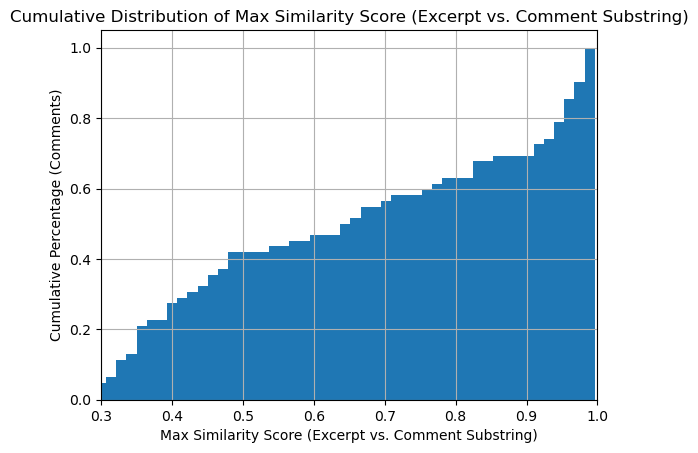

In [25]:
excerpt_not_in_comment = ~llm_class_df_has_excerpt.excerpt_in_comment.astype(bool)
llm_class_df_has_excerpt.loc[excerpt_not_in_comment, "max_diff_ratio"].hist(bins=50, cumulative=True, density=True)

plt.ylabel("Cumulative Percentage (Comments)")
plt.xlabel("Max Similarity Score (Excerpt vs. Comment Substring)")
plt.xlim(0.3,1)
plt.show()

In [156]:
llm_class_df_has_excerpt.loc[excerpt_not_in_comment & (llm_class_df_has_excerpt.max_diff_ratio > 0.90), ["comment_text", "excerpt", "max_diff_ratio"]].sample(10)

,comment_text,excerpt,max_diff_ratio
913,"My father has it, it's awful we had to sell his house and most of his stuff, he's currently in a seniors residence but they want him out. My sister has him at her place during the day, but that's not working as he gets what's called sundowning. I'm afraid he's going to hurt someone or the police are going to hurt him . It's only because of the PERSON pandemic that he still lives where he is. Nursing home is next, but in Canada they don't want anyone who's trouble, in other words they don't care about the elderly in Canada. I love my father, but for his sake, while he still knows who we are I hope he goes peacefully in his sleep. Imagine being in a place, not remembering who we are, or even if we were just there, and abuse is rampant in Canadian nursing homes. I make little money, so I'm basically powerless. He already forgets where he is, doesn't remember seeing us in the very same day, he doesn't wash, and fights and tries to get people out of their cars because he thinks there his. This is brutal.","""He fights and tries to get people out of their cars because he thinks there his.""",0.968750
1089,"Wow what a great video about dementia. I lost my mother 5 years ago to dementia. All of this makes so much sense. I learned to talk about right now . I never would tell my mom no. Instead I would say when she wanted me to take her ""home"" that I had to bring the car around and then leave. It was so hard and broke my heart to actually lie to her but it was the best I could do. She would of forgotten by the time I came back but still. Unfortunately for me I was going thru an illness that I no longer could work. .I didn't feel like driving.as much.. So I started calling her every morning. That worked out but I still tried to go see her. She was about 1 1/2 hours away. My mom got very bad before she passed. She would be up all night and was trying to get out but luckily she was in a very secure place and they took very good care of her. I recommend anyone with a loved one with dementia to watch this or really anyone who want to know more about dementia.","""She was trying to get out but luckily she was in a very secure place and they took very good care of her.""",0.963415
1220,"I had my grandpa with dementia who thought he was still the Bank manager as he was until retired, and we are his junior subordinates. He passed away in his 80's","""He thought he was still the Bank manager as he was until retired.""",0.980769
1319,I love how you are showing people what its really like. My mother just died in April from covid in which one of the nurses brought in and dementia. My mom was just this bad. She would call me 9 times a day crying her eyes out wanting me to come and get her from the nursing home in which she called it the hospital.I love my mom dearly but it broke my heart to see her this way.May she rest In peace..i love my angel above. So i understand what you are going through God be with you.,"""My mom would call me 9 times a day crying her eyes out wanting me to come and get her from the nursing home in which she called it the hospital.""",0.955752
801,"This was actually no help. My father sees people in the house all the time. Will sit there and cpunt the people. 25 people in the house or there were 15 people in his bed or he couldnt take a shower cuz someone was in there. It never ends. Someone is taking the tire off the car, I mean it is always something. So its not an object that he is seeing that he is misinterpreting.","""My father sees people in the house all the time. Will sit there and count the people. 25 people in the house or there were 15 people in his bed or he couldnt take a shower cuz someone was in there.""",0.993506
79,Losing my Great Grandma was one of the hardest things I had to go through. She was literally my best friend for almost 18 years. By the end of her life she had started calling me by my grandmothers name and would ask to see her long dead siblings. \nIt wa

In [159]:
llm_class_df_has_excerpt.loc[excerpt_not_in_comment
                 & (llm_class_df_has_excerpt.max_diff_ratio > 0.70) 
                 & (llm_class_df_has_excerpt.max_diff_ratio < 0.90), 
                 ["comment_text", "excerpt", "max_diff_ratio"]].sort_values("max_diff_ratio")


,comment_text,excerpt,max_diff_ratio
592,My husband is the same way none stop..BUT what can I do with him telling me that he sees men in bed with me!! This is all day Everyday.. I'm going crazy cause I'm not doing anything but this is what he sees And he sees people men in our house he's always telling me that he can't take it him arguing with me Everyday he's on medication but the hallucinations doesn't go away .,"""he sees men in bed with me"" and ""he sees people men in our house""",0.708333
1253,"This is taking over my neighbor at the moment- It started with him forgetting where stuff was and that we were helping him with stuff and it just- deteriorated. he started talking to people who werent there, trying to drive his Car to dead friends houses, And the straw that broke the camels back was when he called the police on a break in when it was me deilvering him some soup my mom had made him- that wasnt fun explaining to the sherriff what was going on. Finally he deteriorated so far he couldnt live alone, and his son put him in a home while he was renevating his house so he could take him back to live with him and his wife and kids. \ni couldnt imagine a worst way for a decorated war hero to go. He was an PERSON, better at trapping than anyone i ever knew and was the staunchest old man i ever knew and i treated him like the grandfather i didnt have. Hopefully he will be back soon, living with his son in his old house, along side the only person he remembers, his son.","""He started talking to people who weren't there, trying to drive his car to dead friends houses, and called the police on a break in when it was me delivering him some soup.""",0.713235
37,"Hi Dr. PERSON,\nI’m so happy that I stumbled upon your channel. My best friend is suffering from early onset Alzheimer’s & going through your videos really helped me understand her situation a lot better. \nI don’t live close to my friend, but am in contact with her wonderful husband through phone calls & texts. Today we spoke & my heart broke for him. He is exhausted beyond belief between work, taking care of my friend & raising their autistic son, but yet he’s always had a calm approach regarding his families devastating situation, until today. \nHe was crying when we spoke, my friend told him that she no longer loves him anymore & to move out. My friend can barely speak, so her & her husband have kind of developed a language all their own, but she can’t communicate enough to explain the reason behind her anger towards him. He knows it’s the illness speaking, but he told me that what really hurts is that she believes what she is saying at that moment. \nShe’s had hallucinations before, but together we’ve been kind of able to figure out where they were coming from, but we are both totally lost about this one. \nI was hoping you had some ideas of how he can manage this situation with her. He’s her main care taker at home & she’s so angry with him, that she won’t even look at him, where usually she’s very loving & affectionate towards him. He’s really broken over this, so any ideas you have in dealing with this new behavior would be so very appreciated. \nThanks for your time. \nTake care,\n Julie","""My friend told him that she no longer loves him anymore & to move out. He knows it's the illness speaking, but he told me that what really hurts is that she believes what she is saying at that moment.""",0.762821
150,"At the very end of his life my father would show concern for a baby, which he thought was in the next room. I would always go and check on the 'baby' and tell him that the child was fine. Just a few days before he died, I asked him who the baby was, he said, ""It's you"". When I told him I was sitting in front of him and now a adult, he looked at me as if I was rather slow and said ""Yes I know that, but you are also the baby next door as well"". Time doesn't appear so linear to those who are close to death.","""He thought there was a baby in the next room...He s

In [170]:
# Are you being a good bing?
llm_class_df_has_excerpt.loc[excerpt_not_in_comment
                 & (llm_class_df_has_excerpt.max_diff_ratio < 0.50), 
                 ["comment_text", "excerpt", "max_diff_ratio"]].sample(10).sort_values("max_diff_ratio")

,comment_text,excerpt,max_diff_ratio
899,"I met. My. Mom. At 17 year's. Old,. And. In the. End. I took. Care. Of. Her,,. My. Sweet. Mom. Rest ❤️ Mama........","""She was convinced that I was not her daughter.""",0.324324
906,My grandmother has alzheimers its a terrible disease. It's hard to see her like that. She doesn't remember me or my son or her 4 children,"""She thinks she's still married to my grandfather who passed away 10 years ago.""",0.333333
131,"My grandmother has Alzheimer’s, shes been showing signs of Alzheimer’s/dementia since 2017. I don’t know how long she has left so I spend as much time as I can with her.","""She's been convinced that her abusive ex-husband has moved in next door and she's been getting mail from his new wife.""",0.340426
1007,My sweet daddy has dementia. He's in the late stages now..we take care of him at home all those 12 years. Awful sickness for the patient and for his family. He got sick when he was 58. My sweet daddy..,"""He's convinced that he's still working and that he's going to get paid for it.""",0.350000
96,My aunt (she raiaed me)is on the early stages im trying to take of her myself but I know i will need help soon.,"""She keeps saying her abusive ex husband moved in next door. That's not true.""",0.350000
189,I love this ❤️. We did the very same with a patient. Gave her a baby doll we kept for peds and she loved it. Also gave her some towels to fold.,"""She was convinced she was in a hotel and was folding towels for the guests.""",0.350000
1002,My brother was just born and this remained me of him because he can't come home with us he has to stay in the hospital. And in latterly crying my eyes out,"""My mom said that he was taken away by the government and that they were going to use him for experiments.""",0.392857
946,I'm in the exact same place. My dad was diagnosed with dementia a couple years ago and is now in memory care/assisted living. I go see him as much as I can just to make sure he doesn't forget who I am and that he's loved.,"""He's convinced that I'm his brother""",0.392857
357,I work with dementia patients in a nursing home. The secret to helping them is to roleplay in different situations to try and disperse any anxiety they are feeling. It's no use arguing with them.,"""one patient was convinced that her husband was coming to pick her up""",0.428571
832,"My grandpa had dementia and he forgot who I was. I was in the car with him, my mom and my grandma and he asked who is this girl?","""He asked who is this girl? My mom said it's your granddaughter and he said no, she's not.""",0.462687
